In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support,confusion_matrix
import seaborn as sns
import csv

# ◆データ概要

In [2]:
kick = pd.read_csv("ks-projects-201801.csv")
kick.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
kick.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


# ◆説明変数の選別（課題共通設定の対応）

通し課題の共通設定に合わせて、選別 。使用しない列は削除。 

<通し課題で使用可能な説明変数>  
ID  
name  
category  
main_category  
currency  
deadline  
launched  
state  
country  
goal  
usd_goal_real   
  

In [4]:
drop_columns = ['pledged','usd pledged','backers','usd_pledged_real']
kick = kick.drop(drop_columns, axis = 1)

# ◆残った説明変数について分析  
  
①各列毎のレコード件数、欠損値を確認  

In [5]:
kick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 11 columns):
ID               378661 non-null int64
name             378657 non-null object
category         378661 non-null object
main_category    378661 non-null object
currency         378661 non-null object
deadline         378661 non-null object
goal             378661 non-null float64
launched         378661 non-null object
state            378661 non-null object
country          378661 non-null object
usd_goal_real    378661 non-null float64
dtypes: float64(2), int64(1), object(8)
memory usage: 31.8+ MB


In [6]:
kick.isnull().sum()

ID               0
name             4
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

name列には4行、欠損値が存在する事が分かった。  
全体として37万件以上あり、データ量としては十分であるため、欠損値を含むレコードは削除する。

In [7]:
#name列に欠損値を含むレコードを削除する。
kick = kick.dropna()
kick.isnull().sum()

ID               0
name             0
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64


②相関係数を確認

,ID,goal,usd_goal_real
ID,1.000000,0.001678,0.001853
goal,0.001678,1.000000,0.942692
usd_goal_real,0.001853,0.942692,1.000000


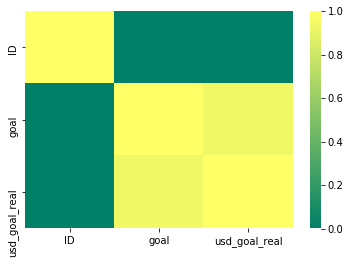

In [8]:
display(kick.corr())
sns.heatmap(kick.corr(),cmap="summer")

In [ ]:
%%time

df_buzz = pd.read_csv("buzzword.csv")
kick = kick.assign(buzz=0)

idx_row = 0

for kc_row in kick.iterrows():
    n = 0
    kc_str = kc_row[1]
    for df_index, df_row in df_buzz.iterrows():
        df_str = df_row[0]
        if df_str in kc_str:
            n += 1
    kick.iloc[idx_row,11] = n
    idx_row += 1
    #print(idx_row,end=",")


# ◆説明変数の選別（学習に使用しない変数の削除）

学習に使用しないと判断した列は削除。 

ID：単なるIDなので、プロジェクト成否に関連はないと判断  
name：プロジェクト名称のため、プロジェクト成否に関連はないと判断  
category：種類が多すぎ、且つ'main_category'に類似の情報が存在するため、不要と判断  
currency:通貨＝国と考えると'country'と類似の項目。当該項目は不要と判断  
goal:'usd_goal_real'と通貨単位が異なるだけで、同じ意味をもつ列。全プロジェクトでUSDで評価できる'usd_goal_real'の採用が望ましいため、当該項目は不要  
  

In [ ]:
drop_columns = ['ID','name','category','currency','goal']
kick = kick.drop(drop_columns, axis = 1)

# ◆カテゴリ変数の変換

カテゴリ変数をone-hot表現に変換する

In [ ]:
kick = pd.get_dummies(kick, columns=['main_category','country'])
kick.head()

# ◆日付データの変換  
'launched'プロジェクト開始日と、'deadline'からプロジェクトの期間を算出可能。説明変数として利用する。  


In [ ]:
#datetime64[ns]型に変換
kick['deadline'] = pd.to_datetime(kick['deadline'], format='%Y-%m-%d %H:%M:%S')
kick['launched'] = pd.to_datetime(kick['launched'], format='%Y-%m-%d %H:%M:%S')

#日単位で差分を計算し、新しい列'period'として追加
kick['period']=(kick['deadline']-kick['launched']).astype('timedelta64[D]') 

#不要列の削除(deadlineはその時点の景気情報等を含んでいる可能性があるため残す)
drop_columns = ['launched']
kick = kick.drop(drop_columns, axis = 1)
kick.head()


# ◆無相関化と標準化

'usd_goal_real'と'period'が量的変数のため、無相関化、標準化の要否を検討する。

まず、上記２変数の相関係数を確認する。

In [ ]:
df=kick[['usd_goal_real','period']]
display(df.corr())
sns.heatmap(df.corr(),cmap="summer")

上記の通り相関関係がない事が分かったため、無相関化は不要と判断。

次に標準化については、２変数の絶対値に差があるか確認する。

In [ ]:
display(df.describe())

上記の通り、差がある事が確認されたため、標準化を行う。ただし、学習用データに対して行う必要があるため、学習用データとテスト用データに分割した後に標準化を行う事とする

# ◆正解ラベルの変換  


In [ ]:
# stateについて，live（実施中）は取り除き，successful = 1，それ以外 = 0とする
#  ※ここは変更しないこと
kick = kick[kick["state"]!="live"]
kick["state"] = kick["state"]=="successful"


# ◆説明変数データ(X)と、正解ラベル(y)に分割

In [ ]:
#X = kick[kick.columns[1:]]
#y = kick[kick.columns[0]]

#正解ラベル以外をXに、正解ラベルをyに設定
y = kick['state']
X = kick.drop('state', axis =1)

# ◆学習用データとテスト用データに分割  
①まずは学習用データとテスト用データを分割する  
②分割方法は通し課題の共通設定に合わせて、ホールドアウト法を採用  

In [ ]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

# ◆標準化
'usd_goal_real'と'period'の標準化を行う。  
ただし、テスト用データの標準化は、学習用データから算出された平均および標準偏差を使用する。  
(テスト用データは予見不可なデータの扱いであり、その統計量は知り得ないため)


In [ ]:
#学習用データから平均および標準偏差を算出
t_me_goal = np.mean(X_train['usd_goal_real'])
t_std_goal = np.std(X_train['usd_goal_real'])
t_me_period = np.mean(X_train['period'])
t_std_period = np.std(X_train['period'])
t_me_buzz = np.mean(X_train['buzz'])
t_std_buzz = np.std(X_train['buzz'])

#学習用データの標準化
X_train['usd_goal_real'] = (X_train['usd_goal_real'] - t_me_goal) / t_std_goal
X_train['period'] = (X_train['period'] - t_me_period) / t_std_period
X_train['buzz'] = (X_train['buzz'] - t_me_buzz) / t_std_buzz

#テスト用データの標準化
X_test['usd_goal_real'] = (X_test['usd_goal_real'] - t_me_goal) / t_std_goal
X_test['period'] = (X_test['period'] - t_me_period) / t_std_period
X_test['buzz'] = (X_test['buzz'] - t_me_buzz) / t_std_buzz




# ◆ハイパーパラメータの最適値探索  
  
  GridSearchを使用し、学習時に使用するハイパーパラメータの最適値を探索する。  
  今回使用するSVMでは、学習に数時間を要するため、GridSerch実行時の学習用データは一部のデータにて限定し探索する    
  学習時は探索で得られたハイパーパラメータにて、全学習用データを用いた学習を行う事とする。  

In [ ]:
%%time

#GridSearch用データの抽出(1,０００件)
X_train_gs = X_train.sample(n=1000)
y_train_gs = y_train.sample(n=1000)


param_grid = {'C': np.logspace(-3, 2, num=6), 'gamma': np.logspace(-3, 2, num=6)}
model = SVC()

clf = GridSearchCV(model, param_grid, cv=5)
clf.fit(X_train_gs, y_train_gs)

print('交差検証法スコア：{:.3f}' .format(clf.best_score_))
print('最適パラメータ：{}' .format(clf.best_params_))



# ◆SVMモデルによる学習、評価

In [ ]:
%%time
# SVMの実行

C = 5
kernel = "rbf"
gamma = 1
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_train, y_train)


# ◆性能指標測定  
  
  ①学習余地が残っているか確認するため、X_trainについて計測  
  ②汎化性能測定のために、X_testについて計測

In [ ]:
#X_trainの性能指標計測
print('＜X_trainの性能指標＞')

# ラベルを予測
y_train_pred = clf.predict(X_train)

# 正答率を計算
accuracy =  accuracy_score(y_train, y_train_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_train_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))


#X_testの性能指標計測
print('＜X_testの性能指標＞')

# ラベルを予測
y_test_pred = clf.predict(X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_test_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

In [ ]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = Other', '正解 = Successful'], 
                        columns=['予測 = Other', '予測 = Successful'])
conf_mat

# ◆今後の改善点

・特定項目だけに標準化を適用できなかった。また、学習用データで標準化を行った後にその係数をテスト用データに適用する具体的な方法が現状不明。

・SVMのハイパーパラメータの最適化のためのGridSearchが実施できていない。

・データ可視化が不足している。（やり方は分かっているが時間切れ）

・SVMによる学習を実行したが、５時間経過しても終了せず。ハイパーパラメータに問題があったか、前処理によるデータ整形に問題があったのか不明。